1


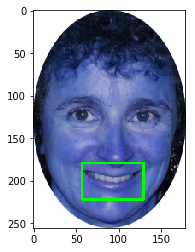

(<matplotlib.image.AxesImage at 0x10f6e7b00>, None)

In [1]:
%matplotlib inline

import numpy as np
#import sys
#sys.path.append('/Users/Vicky/anaconda3/lib/python3.6/site-packages')
import cv2
import matplotlib.pyplot as plt
import time


def convertToRGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



haar_smile_cascade = cv2.CascadeClassifier('/Users/Vicky/OneDrive/Projects/FaceAndSmileAnalyzer/classifiers/mouth.xml')
test = cv2.imread('/Users/Vicky/OneDrive/Projects/FaceAndSmileAnalyzer/test.jpg')

#cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
gray_img = test
gray = cv2.cvtColor(gray_img,cv2.COLOR_BGR2GRAY)

#Detect smile
smile = haar_smile_cascade.detectMultiScale(gray_img,
                                            scaleFactor= 1.7,
                                            minNeighbors=22,
                                            minSize=(25, 25));
print (len(smile))


plt.imshow(gray_img)
for (x,y,w,h) in smile:
    img2 = gray_img[y:y+h, x:x+w];
    cv2.rectangle(gray_img, (x,y), (x+w,y+h), (0,255,0), 2)


img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
#plt.imshow(img2)

corners = cv2.goodFeaturesToTrack(img2,25,0.01,10)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(img2,(x,y),3,255,-1)
    

plt.imshow(gray_img),plt.show()





In [2]:
# Face Matcher Using PCA

import os
import numpy as np
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')
import cv2
import matplotlib.pyplot as plt
import glob

#Step 1: Read the training set 
#data_path = r'/Users/Vicky/OneDrive/Projects/FaceAndSmileAnalyzer/data/'
#main_path = r'/Users/Vicky/OneDrive/Projects/FaceAndSmileAnalyzer/GrayScaleFaces/'
#faces = os.listdir(data_path) #Retrievs the list of images from the folder

image_space = []


faces = glob.glob("/Users/Vicky/OneDrive/Projects/FaceAndSmileAnalyzer/data/*.jpg")


for face in faces:
    img = cv2.imread(face)
    img = cv2.resize(img, (200,200))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #convert img into np array
    arr = np.array(img)
    [w,h] = arr.shape[0], arr.shape[1]
    arr = arr.reshape(w*h)
    image_space.append(arr)

image_space = np.array(image_space, dtype=float)

#find the mean image from the faces database
mean_vector = np.mean(image_space, axis = 0)

#Save the Mean image for reference
cv2.imwrite("mean_img.jpg",mean_vector.reshape(200,200))









True

In [3]:
#Remove the common elements in the faces, by subtracting
#each face from the mean vector
mean_subd = np.array(image_space, dtype=float)

for i in range(0,101):
    mean_subd[i] = abs(mean_subd[i,:] - mean_vector)
#A is the matrix of faces subtracted from mean image. 

In [4]:

#Step 1: Write the Mean subd images in a separate folder for reference
data_path = "/Users/Vicky/OneDrive/Projects/FaceAndSmileAnalyzer/MeanSubdImages"

for i in range(0,101):
    temp = mean_subd[i]
    temp = temp.reshape(200,200)
    cv2.imwrite(data_path + "/" +str(i)+".jpg",temp)


In [5]:
#Compute the scatter matrix A.(A Transpose)
#But A.A(T) is costly as it results in N2 * N2 matrix. 
#But we do A(T) * A which results in M*M matrix

s_matrix = np.matmul(mean_subd,mean_subd.T)  #L matrix

print(s_matrix.shape)




(102, 102)


In [6]:
#calculate eigen vectors and eigen values
from numpy import linalg as LA
from collections import OrderedDict
from sklearn.preprocessing import normalize


eigen_values, eigen_vectors = LA.eig(s_matrix)
eigen_dict = dict(zip(eigen_values, eigen_vectors))
sorted_eigen_dict = OrderedDict()


sorted_keys = sorted(eigen_dict.keys(),reverse = True)
for i in range(0,10):
    sorted_eigen_dict[sorted_keys[i]] = eigen_dict[sorted_keys[i]]

#print(sorted_eigen_dict.values())

#compute the eigen vectors of Covariance matrix
eigen_face_list = []

for key, value in sorted_eigen_dict.items():
    temp = value
    eigen_face = np.matmul(mean_subd.T,temp)
    eigen_face = eigen_face / np.linalg.norm(eigen_face)
    eigen_face_list.append(eigen_face)

eigen_face_list = np.array(eigen_face_list,dtype=float)

#Eigen faces calculated

#Step 1: Read the training set 
data_path = "/Users/Vicky/OneDrive/Projects/FaceAndSmileAnalyzer/EigenFaces/"




for i in range(0,len(eigen_face_list)):
    temp = eigen_face_list[i]
    temp = temp.reshape(200,200)
    cv2.imwrite(data_path + "/" +str(i)+".jpg",temp)





In [7]:
#Compute the feature vector

e_faces = eigen_face_list
# Face Matcher Using PCA

weight_space = []

for i in range(0,len(mean_subd)):
    g = []
    for j in range(0,10):
        g.append(abs(np.matmul(mean_subd[i],eigen_face_list[j])))
    weight_space.append(g)

#weight vector for all the data is found
weight_space = np.array(weight_space,dtype=float)

In [8]:
test = cv2.imread('/Users/Vicky/OneDrive/Projects/FaceAndSmileAnalyzer/test_data/Adrienne_Blaney_11_oval.jpg')

#Assuming g values are correct. 
#Lets try to verify a test image. 


test = cv2.cvtColor(test,cv2.COLOR_BGR2GRAY)
test = cv2.resize(test,(200,200))
[w,h] = test.shape[0], test.shape[1]
test = test.reshape(w*h)

test = np.array(test,dtype=float)
test = abs(test - mean_vector)

gv = []
for i in range(0,10):
    gv.append(np.matmul(test,eigen_face_list[i]))

gv = abs(np.array(gv))


comp = []
for i in range(0,101):
    t =np.linalg.norm(gv-weight_space[i])
    comp.append(t)
    if t < 0.5:
        print("target Image Index - "+ str(i))
        break
    

#For my face
# comp = []
# for i in range(0,101):
#     t =np.linalg.norm(gv-weight_space[i])
#     comp.append(t)
#     if t < 7606:
#         print("target Image Index - "+ str(i))
#         print(t)
#         break






target Image Index - 29
